## Load useful libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
from statsmodels.tsa.stattools import grangercausalitytests

## User settings

In [2]:
data_directory = 'output'
granularity = 'M15' # This data contains currency pair closing prices in 15-minute intervals

tz_to_use = timezone('US/Eastern')  # because Trump's announcement occurred in Washington D.C.

epoch_start = datetime.datetime(2024, 1, 1, 0, 0, 0, tzinfo = tz_to_use).timestamp()

# 4 p.m. ET was the time the announcement began
epoch_liberation_day = datetime.datetime(2025, 4, 2, 16, 0, 0, tzinfo = tz_to_use).timestamp() 

# Granger causality parameters
maxlag = 50
test = 'ssr_chi2test'

## Load the data

In [3]:
df = pd.read_parquet(data_directory + '/' + granularity + '.parquet').sort_values(by = ['instrument', 'time_iso'])
df = df[df['time'] >= epoch_start]
df = df.copy()

instrument_list = list(df['instrument'].unique())

## Define readable versions of currency pairs' symbols

In [4]:
ylabel_dict = {}
ylabel_dict['AUD_USD'] = 'US Dollars per Australian Dollar'
ylabel_dict['EUR_USD'] = 'US Dollars per Euro'
ylabel_dict['GBP_USD'] = 'US Dollars per British Pound'
ylabel_dict['NZD_USD'] = 'US Dollars per New Zealand Dollar'
ylabel_dict['USD_CAD'] = 'Canadian Dollars per US Dollar'
ylabel_dict['USD_CHF'] = 'Swiss Francs per US Dollar'
ylabel_dict['USD_JPY'] = 'Japanese Yen per US Dollar'

## Run the Granger causality tests

From https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html:

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [5]:
causality_test_lags_p_values = {}

for i, instrument in enumerate(instrument_list):
    df_to_use = df[df['instrument'] == instrument].sort_values(by = 'time').copy()
    x = df_to_use['mid_c'].values
    dummy_variable_time_series = [int(q) for q in df_to_use['time'].values > epoch_liberation_day]

    df_temp = pd.DataFrame({'x' : x, 'dummy' : dummy_variable_time_series})
    X = df_temp.to_numpy()
    
    test_result = grangercausalitytests(X, maxlag = maxlag, verbose = False)
    p_values = [test_result[i+1][0][test][1] for i in range(maxlag)]
    causality_test_lags_p_values[instrument] = p_values

/home/emily/venvs/ml/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## Plot the results

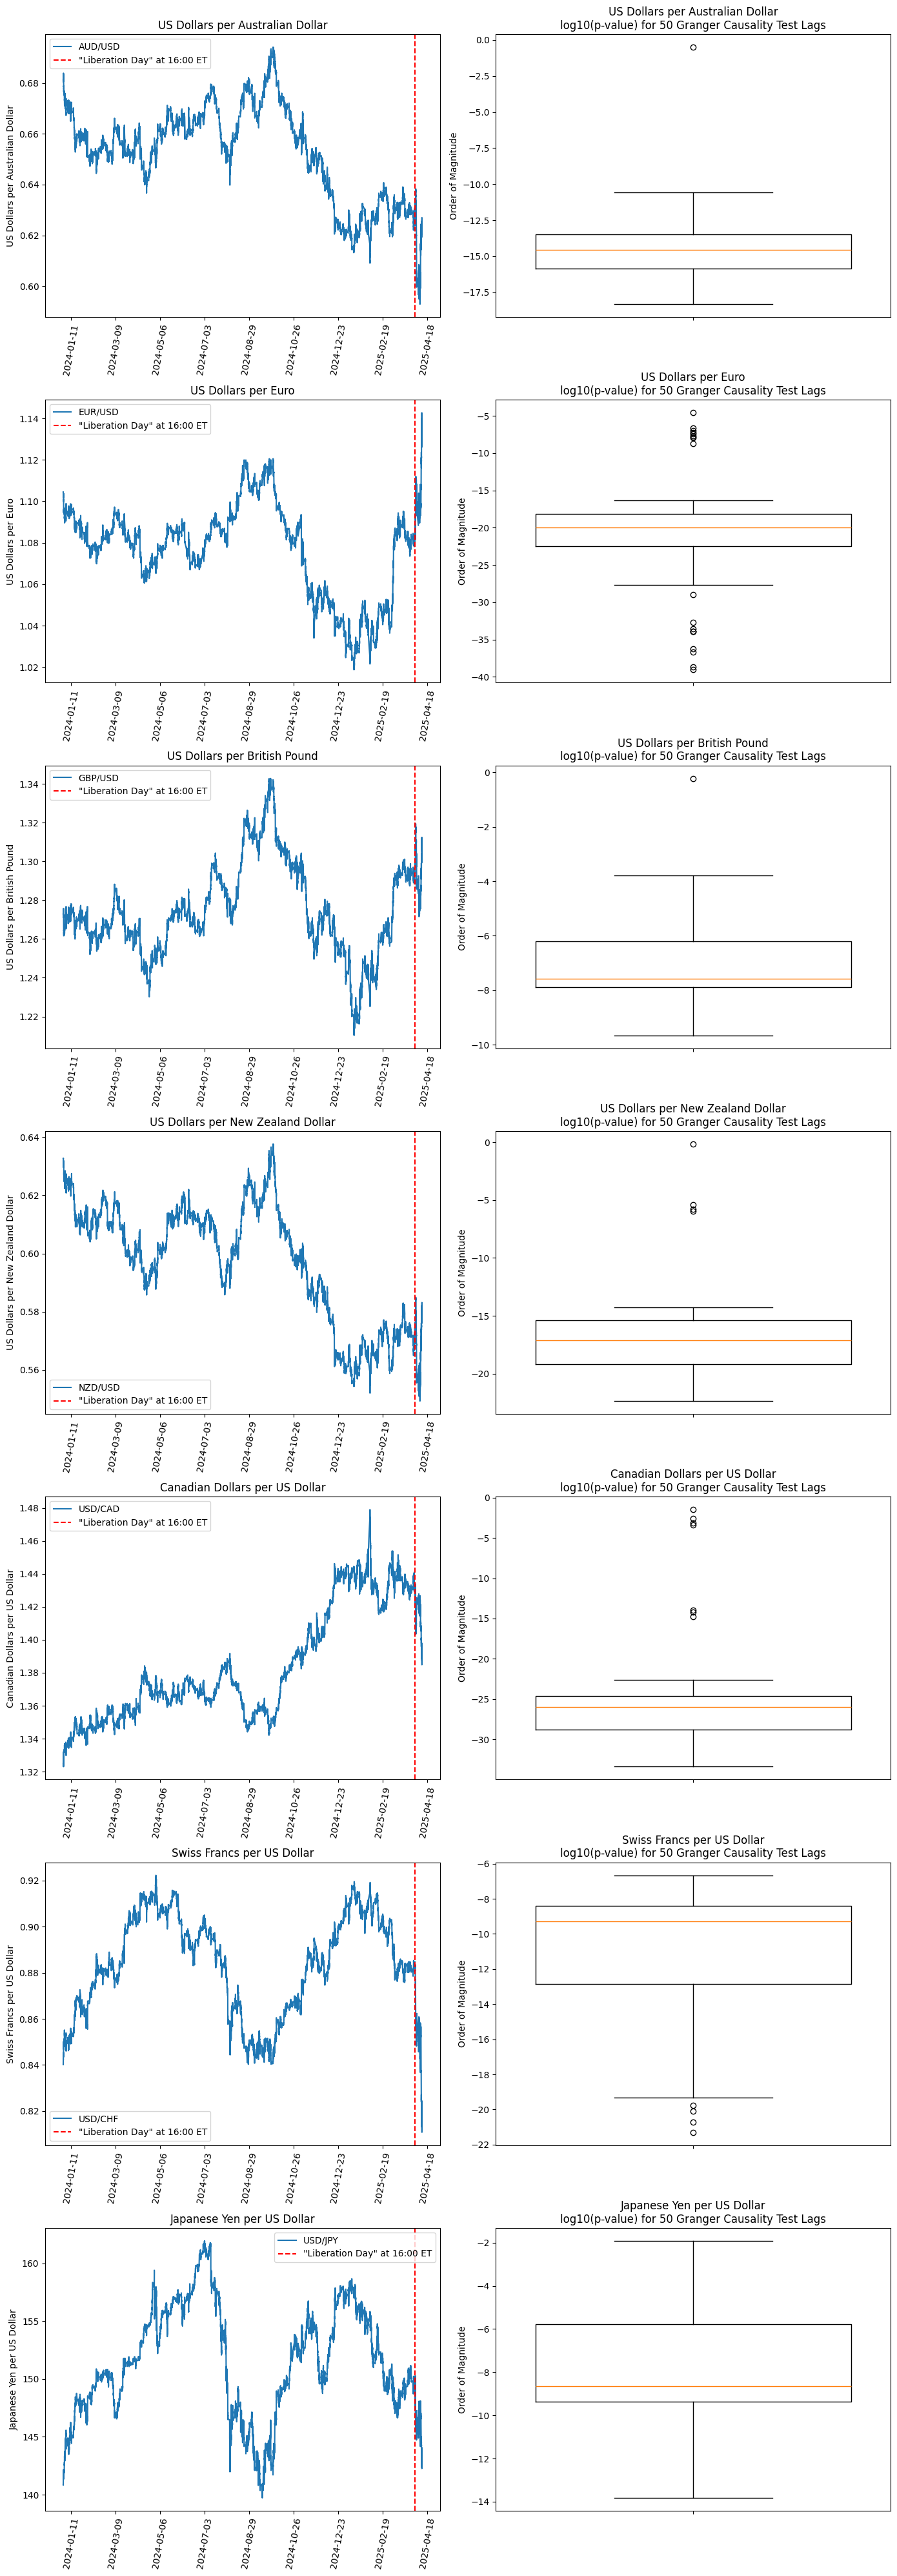

In [10]:
plt.figure(figsize = [14, 40])
for i, instrument in enumerate(instrument_list):
    df_to_use = df[df['instrument'] == instrument].sort_values(by = 'time').copy()
    
    plt.subplot(len(instrument_list), 2, (i * 2) + 1)
    plt.plot(df_to_use['time'], df_to_use['mid_c'], label = instrument.replace('_', '/'))
    plt.axvline(epoch_liberation_day, linestyle = 'dashed', color = 'red', label = '"Liberation Day" at 16:00 ET')
    x_ticks_epoch = plt.xticks()[0]
    x_ticks_date = [str(datetime.datetime.fromtimestamp(q).date()) for q in x_ticks_epoch]
    plt.xticks(x_ticks_epoch[1:-1], x_ticks_date[1:-1], rotation = 80)
    plt.ylabel(ylabel_dict[instrument])
    plt.title(ylabel_dict[instrument])
    plt.legend()
    plt.tight_layout()

    n = len(causality_test_lags_p_values[instrument])
    order_of_magnitude = np.log10(causality_test_lags_p_values[instrument])
    
    plt.subplot(len(instrument_list), 2, (i * 2) + 2)
    plt.boxplot(order_of_magnitude, widths = 0.8)
    plt.ylabel('Order of Magnitude')
    
    plt.title(
        ylabel_dict[instrument] + '\n'
        + 'log10(p-value) for ' + str(n) + ' Granger Causality Test Lags'
    )
    
    plt.xticks([1], [''])
    plt.tight_layout()
    
plt.show()
#plt.savefig(data_directory + '/granger_test_study.png')
plt.close()

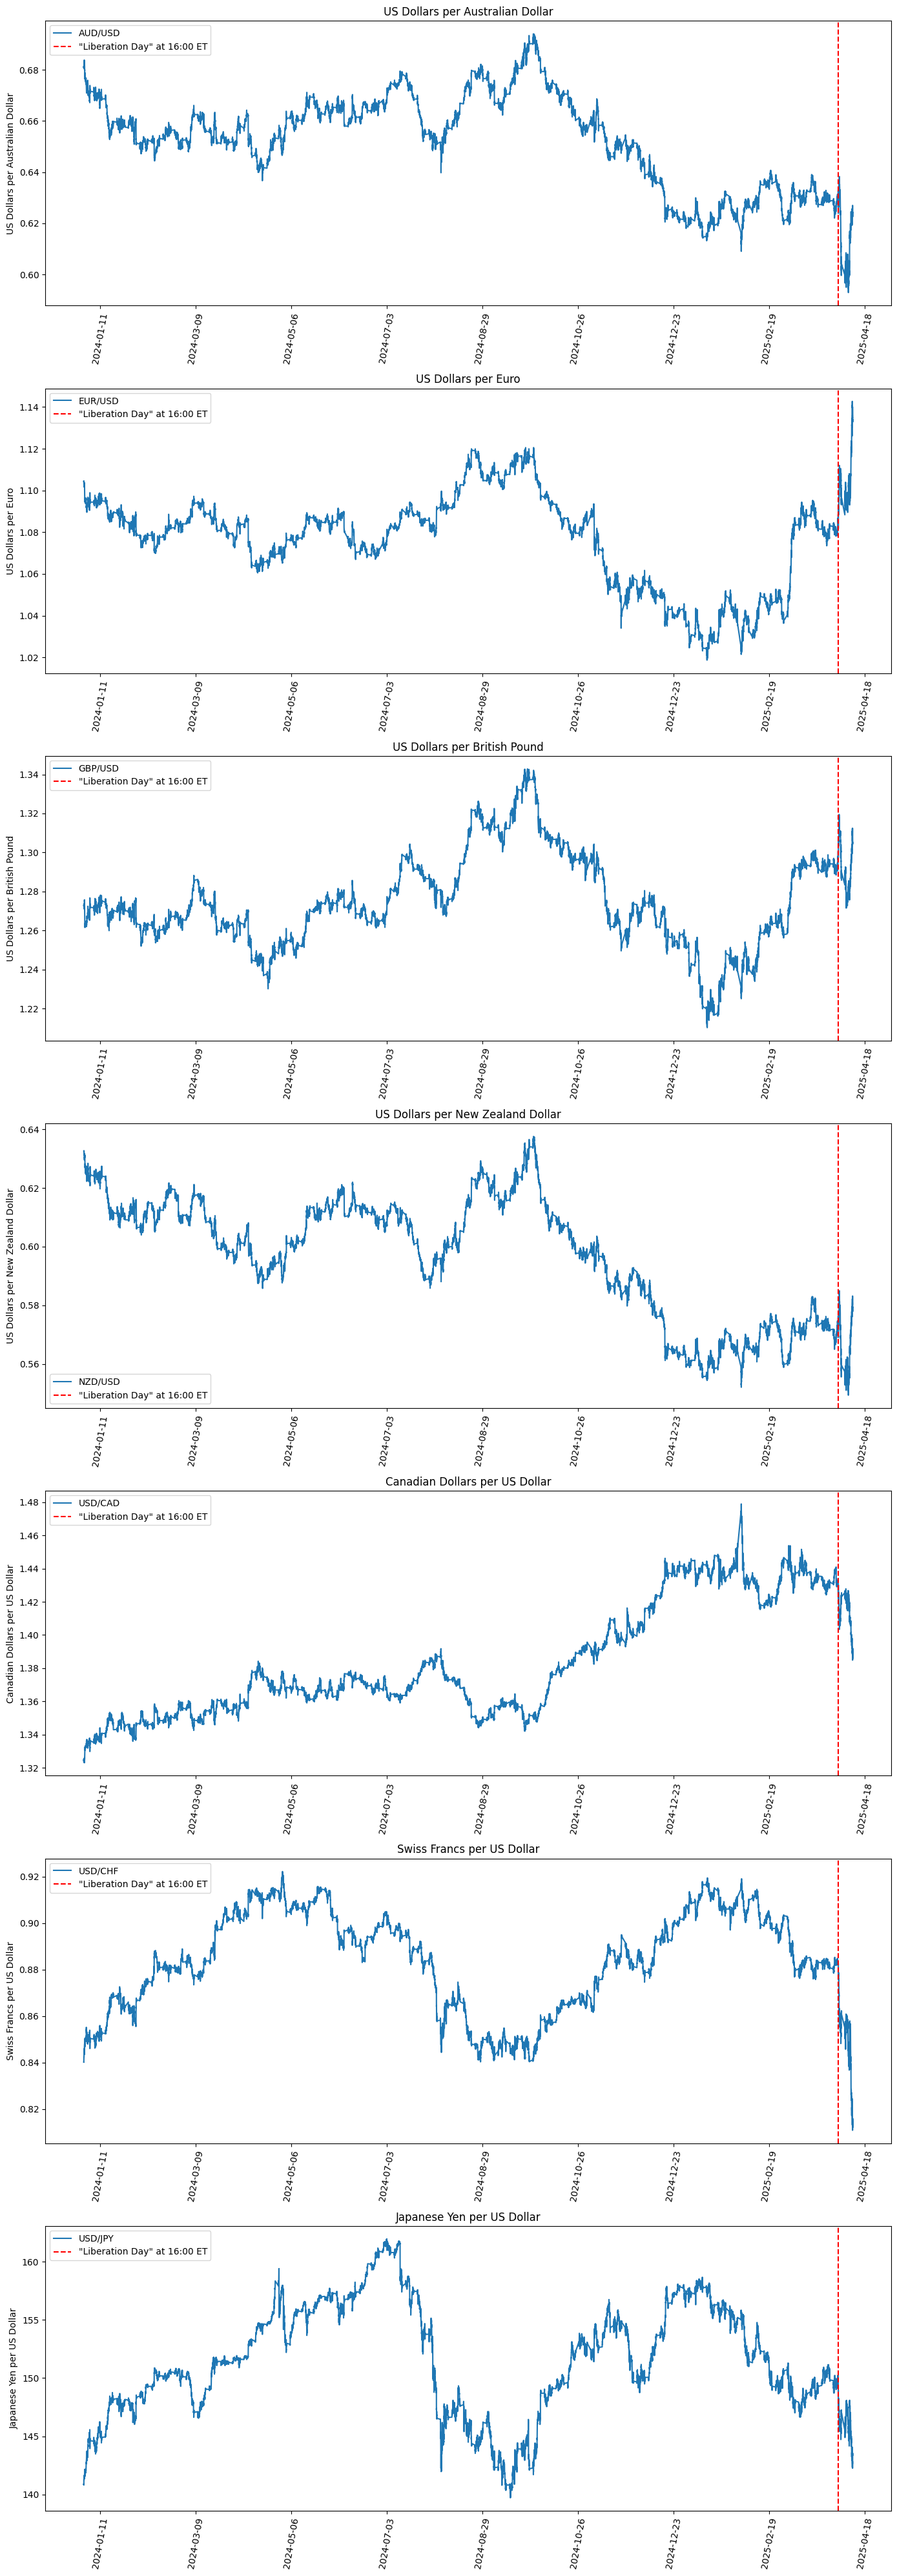

In [9]:
plt.figure(figsize = [14, 40])
for i, instrument in enumerate(instrument_list):
    df_to_use = df[df['instrument'] == instrument].sort_values(by = 'time').copy()
    
    plt.subplot(len(instrument_list), 1, i + 1)
    plt.plot(df_to_use['time'], df_to_use['mid_c'], label = instrument.replace('_', '/'))
    plt.axvline(epoch_liberation_day, linestyle = 'dashed', color = 'red', label = '"Liberation Day" at 16:00 ET')
    x_ticks_epoch = plt.xticks()[0]
    x_ticks_date = [str(datetime.datetime.fromtimestamp(q).date()) for q in x_ticks_epoch]
    plt.xticks(x_ticks_epoch[1:-1], x_ticks_date[1:-1], rotation = 80)
    plt.ylabel(ylabel_dict[instrument])
    plt.title(ylabel_dict[instrument])
    plt.legend()
    plt.tight_layout()
    
plt.show()
plt.close()